### The German Traffic Sign Benchmark

Student Name 1: Panagiotis Michalopoulos

Student Name 2: Filip Finfando

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [ ]:
# use those numbers to change range in the next cell
! wc -l ./data/bin_labels_sorted.txt
! grep "00600.ppm" -B 5 -A 5 -m 1 ./data/bin_labels_sorted.txt --line-number

In [ ]:
number_of_samples = 91213
split_at = 60852
train_samples=55000

In [2]:
import numpy as np
import cv2

IMG_HEIGHT = 600
#SIGN_SIZE = (224, 224)
SIGN_SIZE = (32, 32)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt('./data/bin_labels_sorted.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [5]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('../FullIJCNN2013', range(0,600), range(0,split_at))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('../FullIJCNN2013', range(600,900), range(split_at,number_of_samples))

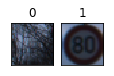

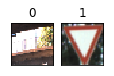

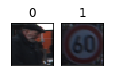

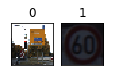

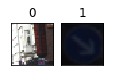

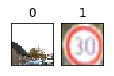

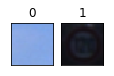

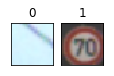

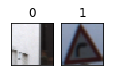

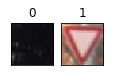

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)

for r in range(10):
    fig = plt.figure(figsize=(8,8))
    for i in range(num_classes):
        ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
        ax.set_title(class_names[i])
        indices = np.where(np.isin(train_labels, class_names[i]))[0]
        plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
    plt.show()

In [15]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:train_samples]
tr_labels = np.array(train_labels)[0:train_samples]
va_signs = np.array(train_signs)[train_samples:split_at]
va_labels = np.array(train_labels)[train_samples:split_at]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

In [16]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Assignment 3.2: Convolutional Neural Network

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras import regularizers, optimizers
from keras.layers.normalization import BatchNormalization

cnn = Sequential()
## If You preprocessed with gray scaling and local histogram equivalization then input_shape = (32,32,1) else (32,32,3)
cnn.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
#cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
#cnn.add(Flatten())
cnn.add(GlobalAveragePooling2D())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(num_classes, activation='softmax'))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 128)       36992     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 6, 6, 128)         512       
__________

In [19]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

class_weight = {0: 1.,
                1: 50.,
               }

data = cnn.fit(
    tr_signs, tr_labels, 
    batch_size=128, epochs=100, verbose=2, 
    validation_data=(va_signs, va_labels), 
    callbacks=[tensorboard, early_stopping], 
    class_weight=class_weight,
)

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 55000 samples, validate on 5852 samples
Epoch 1/100
 - 17s - loss: 0.1933 - acc: 0.9941 - val_loss: 0.0399 - val_acc: 0.9944
Epoch 2/100
 - 17s - loss: 0.1050 - acc: 0.9927 - val_loss: 0.0430 - val_acc: 0.9918
Epoch 3/100
 - 17s - loss: 0.1143 - acc: 0.9923 - val_loss: 0.0474 - val_acc: 0.9913
Epoch 4/100
 - 17s - loss: 0.0649 - acc: 0.9947 - val_loss: 0.0080 - val_acc: 0.9986
Epoch 5/100
 - 17s - loss: 0.0706 - acc: 0.9934 - val_loss: 0.0179 - val_acc: 0.9971
Epoch 6/100
 - 17s - loss: 0.0408 - acc: 0.9963 - val_loss: 0.0108 - val_acc: 0.9976
Epoch 7/100
 - 17s - loss: 0.0537 - acc: 0.9945 - val_loss: 0.0070 - val_acc: 0.9990
Epoch 8/100
 - 17s - loss: 0.0172 - acc: 0.9971 - val_loss: 0.0091 - val_acc: 0.9988
Epoch 9/100
 - 17s - loss: 0.0029 - acc: 0.9991 - val_loss: 0.0056 - val_acc: 0.9990
Epoch 10/100
 - 17s - loss: 0.0036 - acc: 0.9993 - val_loss: 0.0084 - val_acc: 0.9988
Epoch 11/100
 - 17s - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0044 - val_acc: 0.9990
Epoch 12/100
 

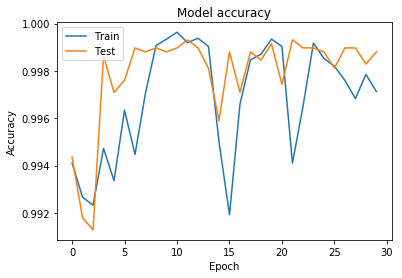

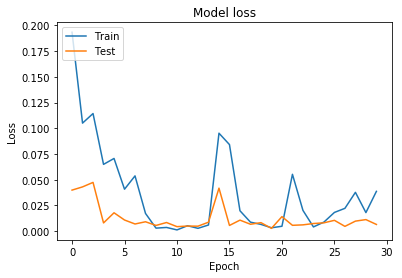

In [20]:
# Plot training & validation accuracy values
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[29968    32]
 [   26   335]]


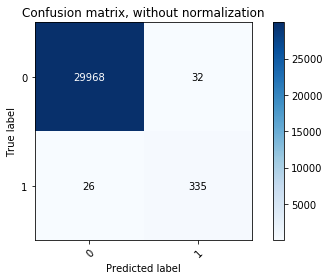

In [40]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(
    np.argmax(te_labels, axis=1), 
    np.argmax(cnn.predict(te_signs), axis=1), 
    classes=np.array([0,1]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

In [41]:
import pickle
with open('./models/test_pred.pickle', 'rb') as fp:
    test_pred = pickle.load(fp)

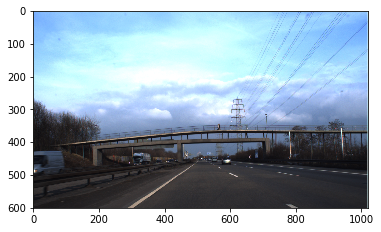

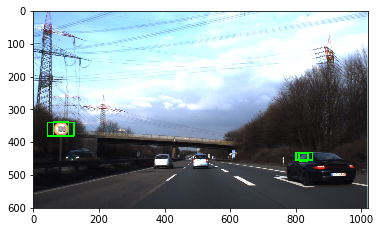

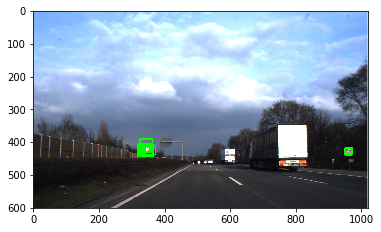

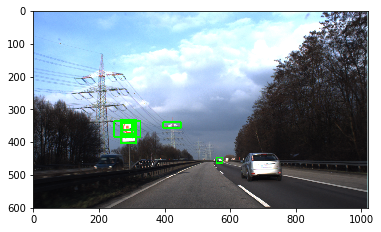

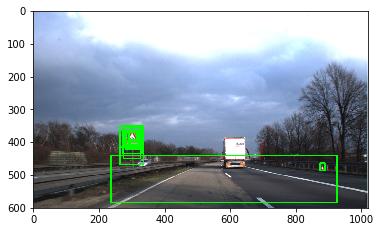

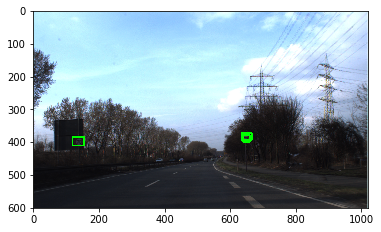

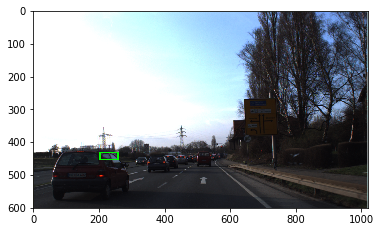

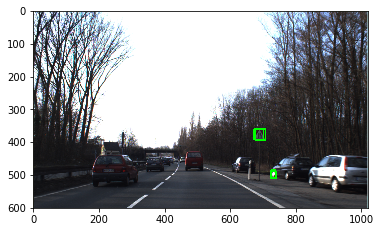

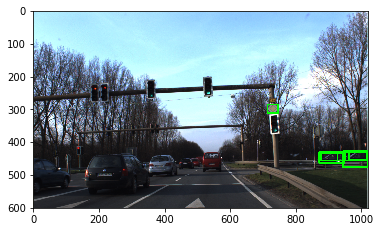

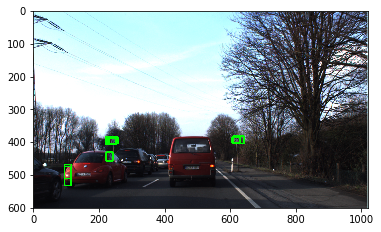

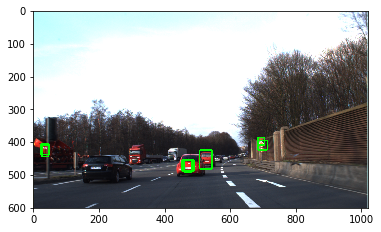

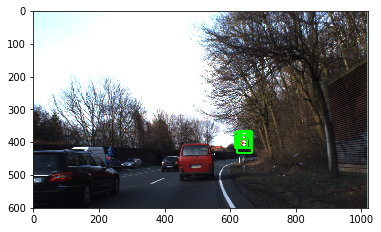

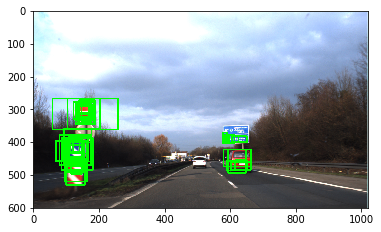

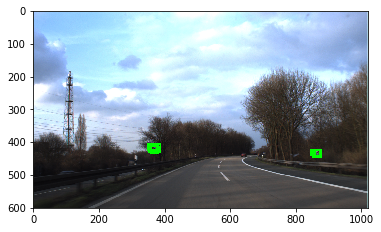

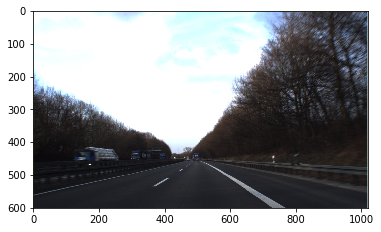

In [47]:
# run some tests
i=0

number_of_images = 15
number_of_boxes_to_draw = 1000

for filename in test_images:
    # Draw predictions
    aux = test_images.get(filename)[0].copy()
    for bbox in test_pred.get(filename)[0][:number_of_boxes_to_draw]:        
        
        # make a prediction
        roi = test_images.get(filename)[0][int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        SIGN_SIZE_CNN = (32, 32)
        roi_resized = cv2.resize(roi, SIGN_SIZE_CNN)
        roi_resized = roi_resized.astype('float32')
        roi_resized /= 255.0
        roi_resized = np.reshape(roi_resized, [1,SIGN_SIZE_CNN[0],SIGN_SIZE_CNN[1],3])
        
        confidence = cnn.predict(roi_resized)
        
        # print rectangle if confidence is large
        # those are boxes that we think have the largest probability to have a traffic sign inside
        if confidence[0][1] > 0.75:
            cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (0,255,0), 3)

        # print contents of box if you like
#         not_a_sign = aux[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
#         plt.imshow(cv2.cvtColor(not_a_sign, cv2.COLOR_BGR2RGB))
#         plt.show()
            

    
    # Draw ground truth
    # this is what we should detect
    if filename in test_files:
        for idx in [i for i, x in enumerate(test_files) if x == filename]:
            bbox = test_bboxes[idx]
#             cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (0,0,255), 3)
            
            # print contents of box if you like
#             sign = aux[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
#             plt.imshow(cv2.cvtColor(sign, cv2.COLOR_BGR2RGB))
#             plt.show()
    
    plt.imshow(cv2.cvtColor(aux, cv2.COLOR_BGR2RGB))
    plt.show()
    i+=1
    if i==number_of_images: break

In [49]:
# serialize model to JSON
model_json = cnn.to_json()
with open("./models/bin_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn.save_weights("./models/bin_model.h5")
print("Saved model to disk")

Saved model to disk


In [11]:
# from keras.preprocessing.image import ImageDataGenerator

# print(len(tr_signs))
# tr_signs_aug = np.array(tr_signs, copy=True) 
# tr_labels_aug = np.array(tr_labels, copy=True)

# datagen = ImageDataGenerator(featurewise_center=False,
#                              featurewise_std_normalization=False,
#                              width_shift_range=0.1,
#                              height_shift_range=0.1,
#                              zoom_range=0.2,
#                              shear_range=0.1,
#                              rotation_range=10.)

# datagen.fit(tr_signs_aug, augment=True)

# # Concatenating the old data with the augmented data
# tr_signs_aug  = np.concatenate((tr_signs, tr_signs_aug), axis=0)
# tr_labels_aug  = np.concatenate((tr_labels, tr_labels_aug), axis=0)

# print(len(tr_signs_aug))

# for x_batch, y_batch in datagen.flow(tr_signs_aug, tr_labels_aug, batch_size=9):
#     # create a grid of 3x3 images
#     fig = plt.figure(figsize=(6,6))
#     for i in range(0, 9):
#         ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
#         ax.set_title(np.argmax(y_batch[i]))
#         plt.imshow(cv2.cvtColor(x_batch[i], cv2.COLOR_BGR2RGB))
#     # show the plot
#     plt.show()
#     break

# train_steps = int(len(tr_signs_aug) / 16)
# valid_steps = int(len(va_signs) / 16)
# data = cnn.fit_generator(datagen.flow(tr_signs_aug, tr_labels_aug, batch_size=16), epochs=100, steps_per_epoch=train_steps, verbose=2, validation_data=(va_signs, va_labels), validation_steps=valid_steps, callbacks=[tensorboard, early_stopping])

# start = time()
# loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
# end = time()
# print('CNN took ' + str(end - start) + ' seconds')
# print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

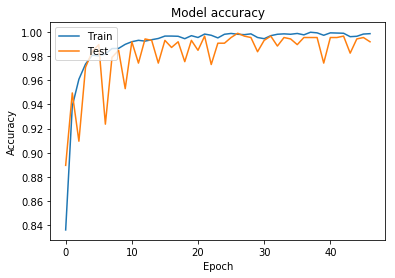

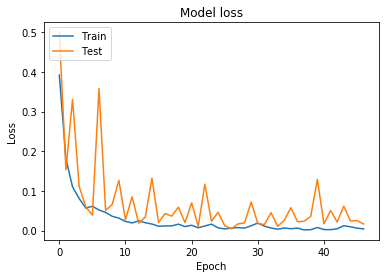

In [12]:
# # Plot training & validation accuracy values
# plt.plot(data.history['acc'])
# plt.plot(data.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(data.history['loss'])
# plt.plot(data.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()